# Basic fitting tests

The purpose of this notebook is to begin the basic fitting functions for a solar flare, to familiarize myself with the problem. The bulk of this code is cannabalized from Daniela Huppenkothen's code from the notebook in the same directory.

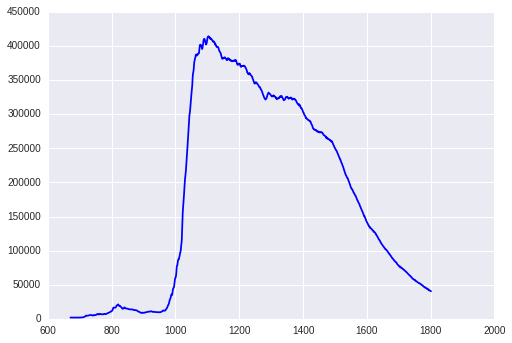

In [1]:
#importing packages

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from stingray import Lightcurve, Powerspectrum

#opening data
data1 = "/home/chris/Documents/QPP/SolarFlareGPs/data/121022782_ctime_lc.txt"
t1, I1 = np.loadtxt(data1, unpack=True)

#basic plot
plt.plot(t1, I1, 'b-')
plt.show()

Alright, we have our basic outline. Let's start with the most basic of options: a Gaussian.

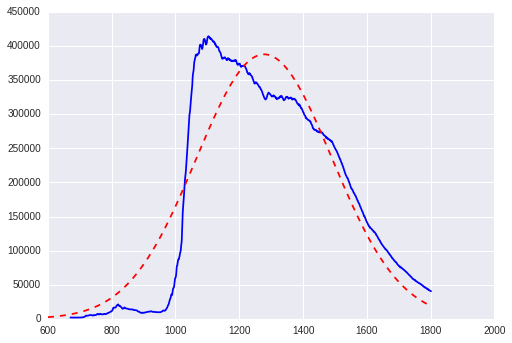

In [16]:
def gauss(x, a, b, c):
    return ((a/np.sqrt(2*np.pi*(c**2)) * np.exp(-1*np.power((x-b),2)/(2*(c**2)))))

#doing a simple fit to the gaussian using a chi-squared fit built into scipy
t = np.linspace(600, 1800, 1000)
popt, pcov = sp.optimize.curve_fit(gauss, t1, I1, p0=[400000, 1200, 600])
Igauss = gauss(t, popt[0], popt[1], popt[2])
plt.plot(t1, I1, 'b-')
plt.plot(t, Igauss, '--r')
plt.show()

This is not the best fit, so let's try a scaled version in the form of a log-normal distribution:

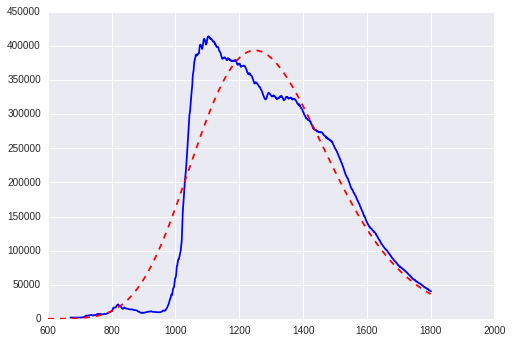

In [3]:
def lognorm(x, a, b, c):
    return ((a/(x*np.sqrt(2*np.pi*(c**2)))) * np.exp(-1*np.power((np.log(x)-b),2)/(2*(c**2))))

#we can approximate the values from our previous fit, using the form:
a = popt[0]
val = (1+((popt[2]**2)/(popt[1]**2)))
mu = np.log((popt[1])/np.sqrt(val))
sigma = np.sqrt(np.log(val))


#repeating the above step for the lognormal function
popt2, pcov2 = sp.optimize.curve_fit(lognorm, t1, I1, p0=[a, mu, sigma])
Ilognorm = lognorm(t, popt2[0], popt2[1], popt2[2])
plt.plot(t1, I1, 'b-')
plt.plot(t, Ilognorm, '--r')
plt.show()


This didn't seem to work only incrementally better, so let's try a Lorentzian method:

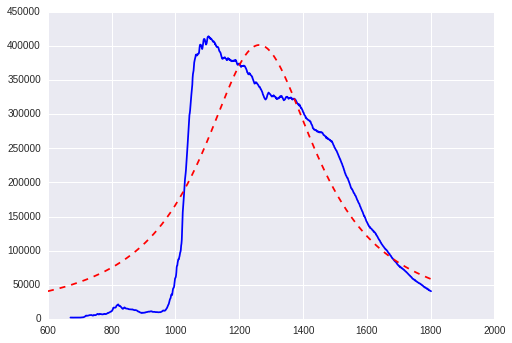

In [4]:
def lorentzian(x, a, b, c):
    return ((a/(np.pi*c))*((c**2)/(np.power((x-b),2)+(c**2))))

#again, repeating the above steps
popt3, pcov3 = sp.optimize.curve_fit(lorentzian, t1, I1, p0=[400000, 1100, 400])
Ilorentz = lorentzian(t, popt3[0], popt3[1], popt3[2])
plt.plot(t1, I1, 'b-')
plt.plot(t, Ilorentz, '--r')
plt.show()

Finally, let's try a piecewise method. Note that this is a non-smooth function so our power spectra will be VERY bad...

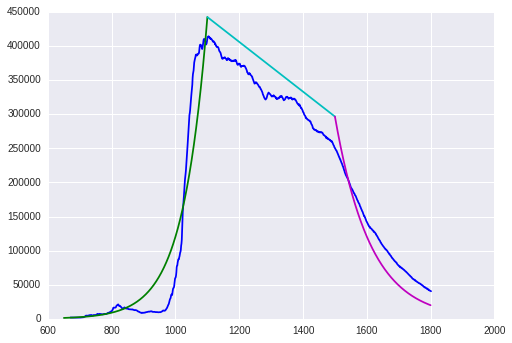

In [10]:
def expf(x, a, b):
    return np.exp((a*(x-b)))

def linef(x, a, b):
    return a*x + b

def linef2 (x, x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    b = y2 - (m*x2)
    return ((m*x) + b)


#rough "by eye" approximation of the function using a piecewise exp-linear-exp function
xl = 1100
xr = 1500
a1 = 1.3e-2
b1 = 100
a3 = -9e-3
b3 = 2900

x1 = np.linspace(650, xl, 500)
x2 = np.linspace(xl, xr, 400)
x3 = np.linspace(xr, 1800, 300)
y1 = expf(x1, a1, b1)
y2 = linef2(x2, xl, expf(xl, a1, b1), xr, expf(xr, a3, b3))
y3 = expf(x3, a3, b3)
plt.ylim(0,450000)
plt.plot(t1, I1, 'b-')
plt.plot(x1,y1,'g-')
plt.plot(x2,y2,'c-')
plt.plot(x3,y3,'m-')
plt.show()

So let's take our piecewise method and apply the fitting function to it:

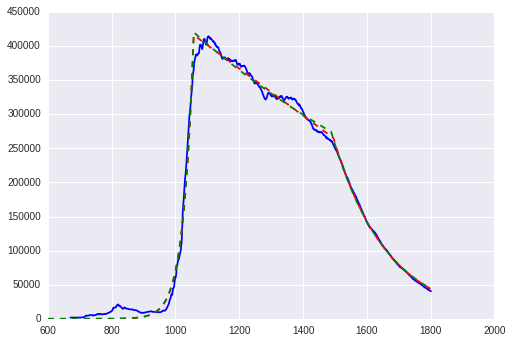

In [32]:
#super slow implementation of a piecewise function
def piecewise(x, xl, xr, a1, b1, a3, b3):
            result = np.empty(len(x))
            for i in range(len(x)):
                    if(x[i]<=xl):
                        result[i] = expf(x[i], a1, b1)
                    elif (x[i]>xl and x[i]<=xr):
                        result[i] = linef2(x[i], xl, expf(xl,a1,b1), xr, expf(xr, a3, b3))
                    elif (x[i]>xr):
                        result[i] = expf(x[i], a3, b3)
            return result
        
def hoggmodel(t, tl, tr, al, yl, ar, yr):
    result = np.empty(t.shape)
    for i in range(len(t)):
        if(t[i]<tl):
            result[i] = np.exp(yl + al*(t[i]-tl))
        elif(t[i]>tr):
            result[i] = np.exp(yr + ar*(tr-t[i]))
        else:
            result[i] = np.exp(yl + (t[i]-tl)*(yr-yl)/(tr-tl))
    return result
        
#parameters pulled from the "by eye" fit in prior cell
params = [xl, xr, a1, b1, a3, b3]
hoggparams = [1050, 1500, a1, np.log(410000), 0.2*a1, np.log(260000)]

popt4, pcov = sp.optimize.curve_fit(piecewise, t1, I1, p0=params)
popt5, pcov = sp.optimize.curve_fit(hoggmodel, t1, I1, p0=hoggparams)

              
Ipw = piecewise(t, popt4[0], popt4[1], popt4[2], popt4[3], popt4[4], popt4[5])
Ihogg = hoggmodel(t, popt5[0], popt5[1], popt5[2], popt5[3], popt5[4], popt5[5])

plt.ylim(0,450000)
plt.plot(t1, I1, 'b-')
plt.plot(t,Ipw,'r--')
plt.plot(t,Ihogg,'g--')
plt.show()


A surprisingly good fit, all things considered. Let's overlay all of them into one plot:

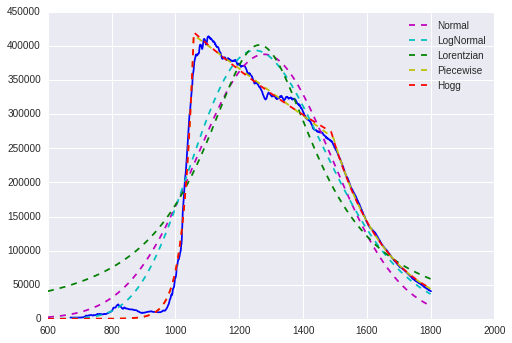

In [37]:
plt.ylim(0,450000)
plt.plot(t1, I1, 'b-')
plt.plot(t,Igauss,'m--', label="Normal")
plt.plot(t,Ilognorm,'c--', label="LogNormal")
plt.plot(t,Ilorentz,'g--', label="Lorentzian")
plt.plot(t,Ipw,'y--', label="Piecewise")
plt.plot(t,Ihogg,'r--', label="Hogg")
plt.legend()
plt.show()

Let's use stingray to find the power spectra of these fits:

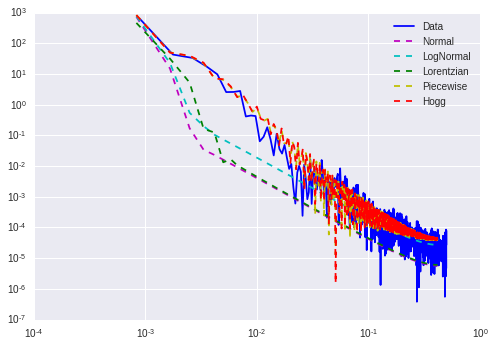

In [38]:
lc = Lightcurve(t1, I1)
lcgauss = Lightcurve(t, Igauss)
lclognorm = Lightcurve(t, Ilognorm)
lclorentz = Lightcurve(t, Ilorentz)
lcpw = Lightcurve(t, Ipw)
lchogg = Lightcurve(t, Ihogg)

ps = Powerspectrum(lc)
psgauss = Powerspectrum(lcgauss)
pslognorm = Powerspectrum(lclognorm)
pslorentz = Powerspectrum(lclorentz)
pspw = Powerspectrum(lcpw)
pshogg = Powerspectrum(lchogg)

plt.loglog(ps.freq, ps.power, 'b-', label="Data")
plt.loglog(psgauss.freq, psgauss.power,'m--', label="Normal")
plt.loglog(pslognorm.freq, pslognorm.power,'c--', label="LogNormal")
plt.loglog(pslorentz.freq, pslorentz.power,'g--', label="Lorentzian")
plt.loglog(pspw.freq, pspw.power,'y--', label="Piecewise")
plt.loglog(pshogg.freq, pshogg.power,'r--', label="Hogg")
plt.legend()
plt.show()

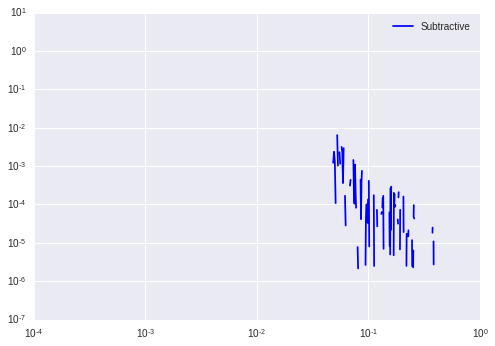

In [31]:
l = len(pspw.power)
power = np.empty(l)
for i in range(l):
    power[i] = ps.power[i]- pspw.power[i]
    
plt.loglog(pspw.freq, power, 'b-', label="Subtractive")
plt.legend()
plt.show()